In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from collections import Counter
from sklearn.model_selection import cross_val_score
import re

from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/MachineLearning/master/dataset/Titanic%20-%20Machine%20Learning%20from%20Disaster/train.csv")

In [3]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


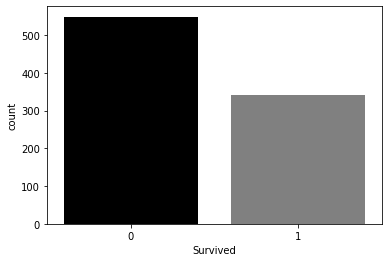

0    549
1    342
Name: Survived, dtype: int64


In [7]:
sns.countplot(train["Survived"], palette = ["black","gray"])
plt.show()
print(train.Survived.value_counts())

In [8]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3st quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier Step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2) 
    
    return multiple_outliers
train.loc[detect_outliers(train,["Age","SibSp","Parch","Fare"])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [9]:
train = train.drop(detect_outliers(train,["Age","SibSp","Parch","Fare"]),axis = 0).reset_index(drop=True)

In [10]:
def preprocess(data):
    
    data.Cabin.fillna('0', inplace = True)
    data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = 1
    data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = 2
    data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = 3
    data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = 4
    data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = 5
    data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = 6
    data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = 7
    data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = 8
    
    data['Sex'].replace('female', 1, inplace =True)
    data['Sex'].replace('male', 2, inplace =True)
    
    data['Embarked'].replace('S', 1, inplace =True)
    data['Embarked'].replace('C', 2, inplace =True)
    data['Embarked'].replace('Q', 3, inplace =True)
    
    data['Age'].fillna(data['Age'].median(), inplace = True)
    data['Fare'].fillna(data['Fare'].median(), inplace = True)
    data['Embarked'].fillna(data['Embarked'].median(), inplace = True)
    
    return data

def group_titles(data):
    
    data['Names'] = data['Name'].map(lambda x: len(re.split(' ', x)))
    data['Title'] = data['Name'].map(lambda x: re.search(', (.+?) ', x).group(1))
    data['Title'].replace('Master.', 0, inplace = True)
    data['Title'].replace('Mr.', 1, inplace = True)
    data['Title'].replace(['Ms.', 'Mlle.', 'Miss.'], 2, inplace = True)
    data['Title'].replace(['Mme.', 'Mrs.'], 3, inplace = True)
    data['Title'].replace(['Dona.', 'Lady.', 'the Countess.', 'Capt.', 'Col.', 'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'the'], 4, inplace = True)
    
    
    

def data_subset(data):
    
    features = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Names', 'Title', 'Age', 'Cabin', 'Fare', 'Embarked']
    lenght_features = len(features)
    subset = data[features].fillna(0)
    
    return subset, lenght_features

def create_model(train_set_size, input_lenght, num_epochs, batch_size, x_test, y_test):
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = input_lenght))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(4, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    
    lr = .001
    adam0 = Adam(lr = lr)
    
    model.compile(loss = "binary_crossentropy", optimizer = adam0, metrics= ['accuracy'])
    
    hist = model.fit(X_train[:train_set_size], Y_train[:train_set_size], validation_data=(x_test,y_test), epochs=num_epochs, batch_size=batch_size, verbose=-1)
    
    return model, hist
    

def plots(history):
    plt.plot(history.history["loss"],label = "Train Loss")
    plt.plot(history.history["val_loss"],label = "Validation Loss")
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(history.history["accuracy"],label = "Train Accuracy")
    plt.plot(history.history["val_accuracy"],label = "Validation Accuracy")
    plt.legend()
    plt.show()

def test(batch_size):
        
    test = pd.read_csv('https://raw.githubusercontent.com/benvictoria17/MachineLearning/master/dataset/Titanic%20-%20Machine%20Learning%20from%20Disaster/test.csv')
    test_ids = test['PassengerId']

    test = preprocess(test)
    group_titles(test)
    testdata, _ = data_subset(test)

    X_test = np.array(testdata).astype(float)

    output = model.predict(X_test, batch_size=batch_size, verbose=0)
    output = output.reshape((418,))

    test_data = pd.DataFrame()
    test_data["PassengerId"] = test_ids
    test_data["Survived"] = output
    
    return test_data

In [11]:
preprocess(train)
group_titles(train)


num_epochs = 100
batch_size = 16

traindata, lengh_features = data_subset(train)

Y_train = np.array(train['Survived']).astype(int)
X_train = np.array(traindata).astype(float)

train_set_size = int(.85 * len(X_train))

X_validation = X_train[train_set_size:]
Y_validation = Y_train[train_set_size:]

model, history_model = create_model(train_set_size, lengh_features, num_epochs, batch_size, X_validation, Y_validation)


loss_and_metrics = model.evaluate(X_validation, Y_validation, batch_size=batch_size)
print ("loss_and_metrics")

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

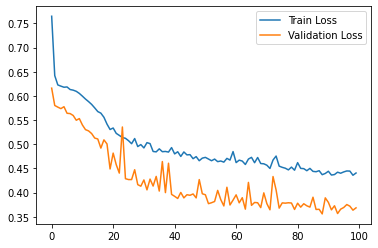

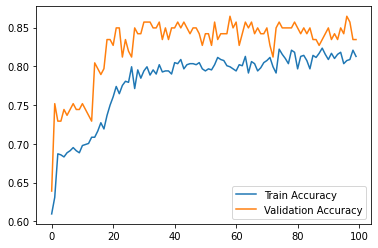

In [12]:
plots(history_model)

In [13]:
predict_data = test(batch_size)
predict_data

,PassengerId,Survived
0,892,0.072602
1,893,0.460436
2,894,0.132969
3,895,0.067385
4,896,0.766363
...,...,...
413,1305,0.074582
414,1306,0.786613
415,1307,0.119180
416,1308,0.074582
